In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2014-06-19,NTRS,2014-06-19,64.54,64.57,63.720,64.12,51.9436,1019102,1.539249e+10
2010-07-14,PM,2010-07-14,49.18,49.73,48.960,49.52,27.1645,5538942,9.115570e+10
2010-01-05,AMGN,2010-01-05,57.33,57.69,56.270,57.22,42.5190,7882800,5.702736e+10
2023-01-27,FISV,2023-01-27,106.04,107.15,105.935,106.49,106.4900,2091748,6.853770e+10
2009-02-26,BDX,2009-02-26,67.67,68.37,65.060,65.10,49.8133,1320098,1.675088e+10


In [3]:
def smoother_filter(close, length=None, poles=None, offset=None, **kwargs):

    # Validate Arguments
    length = int(length) if length and length > 0 else 10
    poles = int(poles) if poles in [2, 3] else 2
    offset = int(offset) if offset else 0
    if close is None: return

    # Calculate Result
    m = close.size
    ssf = close.copy()

    if poles == 3:
        x = np.pi / length # x = PI / n
        a0 = np.exp(-x) # e^(-x)
        b0 = 2 * a0 * np.cos(np.sqrt(3) * x) # 2e^(-x)*cos(3^(.5) * x)
        c0 = a0 * a0 # e^(-2x)

        c4 = c0 * c0 # e^(-4x)
        c3 = -c0 * (1 + b0) # -e^(-2x) * (1 + 2e^(-x)*cos(3^(.5) * x))
        c2 = c0 + b0 # e^(-2x) + 2e^(-x)*cos(3^(.5) * x)
        c1 = 1 - c2 - c3 - c4

        for i in range(0, m):
            ssf.iloc[i] = c1 * close.iloc[i] + c2 * ssf.iloc[i - 1] + c3 * ssf.iloc[i - 2] + c4 * ssf.iloc[i - 3]

    else: # poles == 2
        x = np.pi * np.sqrt(2) / length # x = PI * 2^(.5) / n
        a0 = np.exp(-x) # e^(-x)
        a1 = -a0 * a0 # -e^(-2x)
        b1 = 2 * a0 * np.cos(x) # 2e^(-x)*cos(x)
        c1 = 1 - a1 - b1 # e^(-2x) - 2e^(-x)*cos(x) + 1

        for i in range(0, m):
            ssf.iloc[i] = c1 * close.iloc[i] + b1 * ssf.iloc[i - 1] + a1 * ssf.iloc[i - 2]

    # Offset
    if offset != 0:
        ssf = ssf.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        ssf.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        ssf.fillna(method=kwargs["fill_method"], inplace=True)

    return ssf

In [4]:
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = smoother_filter(df_ticker['close'],length = 5,poles =3).fillna(0)
        results[ticker] = metrics
    except :
        print(ticker)


100%|██████████| 866/866 [03:51<00:00,  3.75it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_25960\2919185316.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(10).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_25960\2919185316.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe                         1.6
Average Daily Turnover (%)    65.2
Average daily pnl (bps)        2.5
dtype: float64

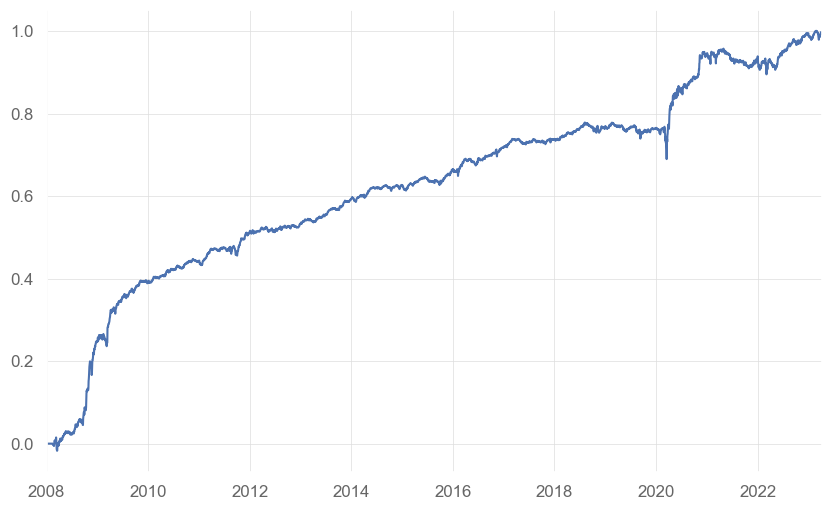

In [5]:
signal = pd.concat(results,axis=1).reindex_like(P).ffill()
signal = signal[P].rolling(10).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = 0
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)
PNL = (signal[P].shift()*R).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Average Daily Turnover (%)':turnover *100,'Average daily pnl (bps)':PNL.mean()*1e4}).round(1)

<Axes: >

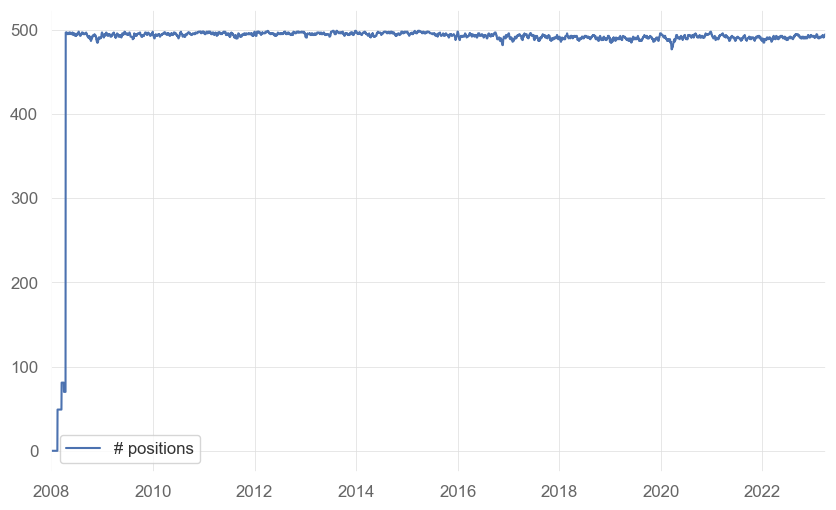

In [6]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

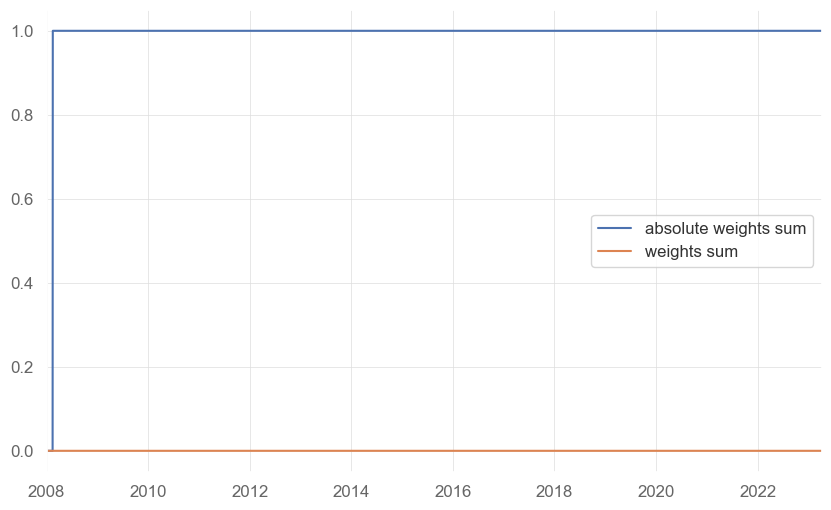

In [7]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)